In [1]:
%run init_notebook.py

In [2]:
from src.utils import load_pd_df, get_dt_index
from src.processing import pd_join_dfs, pd_groupby
import scipy

In [38]:
from src.utils import load_pd_df, save_pd_df, get_dt_index, pd_join_freq, Capturing, cross_corr, pd_df_astype
from src.processing import pd_groupby, pd_join_dfs, adf_test_summary, hausman, plt_stacked_bar
from src.pymc_modelling import get_samp

from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from linearmodels.panel import PanelOLS
from statsmodels.regression.linear_model import OLS
from linearmodels import RandomEffects
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.svar_model import SVAR

In [4]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank, select_order
from statsmodels.tsa.stattools import adfuller

# Questions for today

+ Is the analysis of the perception/ expectation error sufficient
+ Analysis of news data
    + How could I approach the varying composition of overall reporting? -> Main issue no stable relationship (e.g. VAR, PCA)
    + PCA only provides moderate results for that reason
+ Panel data approach
    + First diference of news data (on the day) to represent "news shock"
    + Control variables sufficient -> trade off to sample size bc. of NaN values
    
+ Current research conclusion
    + Weak evidence for impact of media on inflation expectation on the macro level (time series analysis)
        + causality is suggested to flow in different directions
        + only weak evidence for media -> expectation, goes in line with Dräger (2015) which only finds some interaction
    + Stronger evidence for impact of media on infltion expectation on the micro level (panel data)
        + Perception, expectation and delta perceived - expected all are influence by news-shocks

# load data

In [5]:
topics = load_pd_df('lda_topics_smooth2.feather').reset_index()
topics.set_index('date', inplace=True)
topics = topics[[i for i in topics.columns if "_W" in i and "_diff" not in i]]
topics.columns = [i.split("_W")[0] for i in topics.columns]
topics = topics.join(topics.drop(['D_inflation', 'M_policy'], axis=1).sum(axis=1).rename('T_sum'))
topics['T_sum_diff_lag'] = topics.T_sum.drop_duplicates().diff().shift(1)
topics = topics.drop_duplicates()
# topics = topics.rename(columns={'id': 'id_topics'})

hhp = load_pd_df('hhp_processed.feather')
hhp['ecbtrust'] = hhp['ecbtrust'].astype(float)
hhp['week_recorded'] = hhp.date_recorded.dt.to_period('W').dt.to_timestamp()

# pi = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()
pi = load_pd_df("pi.feather")
mir = get_dt_index(load_pd_df('mir.csv'))
bei = load_pd_df('bei.feather')

In [6]:
df = hhp.set_index('date_recorded')[
    [
        'pi_perc', 'id', 'hhinc', 'hhinc_delta', 'hhinc_midpoint', 'delta_pe', 'delta_pe_WY', 'pi_perc_MY', 'pi_perc_WY', 'percprob_war',
        'percprob_covid', 'date_forecast',  'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust',
    ]].drop_duplicates().copy()
df = pd_join_dfs([df, hhp.set_index('date_forecast')[['pi_exp_MY', 'i_exp_MY', 'pi_exp_WY']].drop_duplicates(),],
                 index_name='date_recorded')

In [7]:
df = pd_join_freq(df, topics, "W", True)
df = pd_join_freq(df, mir[['ecb_rate']], "M", True)
df = pd_join_freq(df, pi[['pi_de_Y', 'pi_de_surprise_Y', 'pi_de_estimate_Y']], 'M', True)

df['week_recorded'] = df.index.to_period('W').to_timestamp()
df = df.reset_index(drop=True)

In [8]:
# get pi percption error

In [9]:
sub = df.reset_index().groupby(['date_recorded', 'id'])['pi_perc_MY'].last().dropna().unstack()
sub = sub.loc[:, sub.count() > 7]
sub = pd_join_freq(sub, pi[['pi_de_Y']], freq='M', keep_left_index=False, how='left')
diff = sub.iloc[:, :-1].values - sub.iloc[:, -1].values[:,None]
diff = np.array([diff[:, i][~np.isnan(diff[:, i])].mean() for i in range(diff.shape[1])]) * 100

sub = pd.DataFrame(data=diff, index=sub.iloc[:,:-1].columns, columns=['pi_perc_error']).reset_index(names=['id'])

df = pd.merge(df, sub, left_on='id', right_on='id', how='left')

In [10]:
# check

In [11]:
df.groupby(['id', 'week_recorded']).pi_perc.last().unstack().count(axis=1).describe()

count    49546.000000
mean         1.937573
std          1.801603
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         10.000000
dtype: float64

# Expectation and perception

## Perception error: What explains the perception error in the cross-section

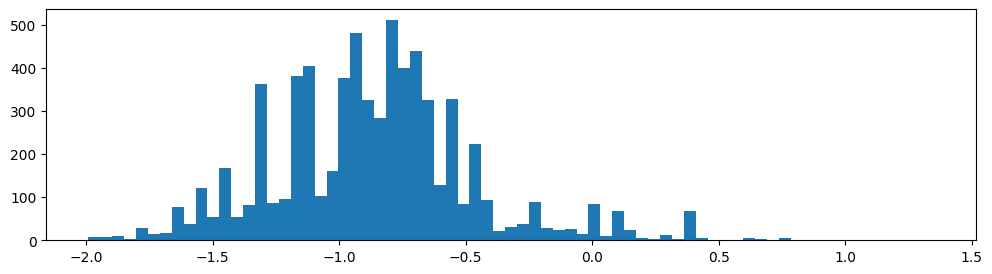

In [12]:
plt.hist(diff, bins='fd');

In [24]:
_ = df.set_index('id').pi_perc_error.dropna().drop_duplicates()
sub = hhp[
    [
        'hhinc_midpoint', 'eduwork', 'is_food_shop', 'is_invest_shop', 'is_unempl', 'is_homeown', 'id',
    ]].set_index('id').loc[_.index].copy()
sub = sub.join(_).reset_index().groupby('id').last()
dep_var = 'pi_perc_error'

In [25]:
DICT_PARSE_COLS.update({'debt': 'category'})
sub = pd_df_astype(sub, DICT_PARSE_COLS)

In [26]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1401 entries, 700030.0 to 3000138.0
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   hhinc_midpoint  1376 non-null   float64
 1   eduwork         1401 non-null   object 
 2   is_food_shop    1401 non-null   bool   
 3   is_invest_shop  1401 non-null   bool   
 4   is_unempl       1401 non-null   bool   
 5   is_homeown      1401 non-null   bool   
 6   pi_perc_error   1401 non-null   float64
dtypes: bool(4), float64(2), object(1)
memory usage: 49.3+ KB


In [27]:
ols_data = sub.dropna().copy()
ols_data.shape

dict_cat_cols = {}
for col in ols_data:
    if ols_data[col].dtype == 'O':
        ols_data = ols_data.join(pd.get_dummies(ols_data[col], prefix=col)).iloc[:, :-1]
        ols_data = ols_data.drop(col, axis=1)
    
ols_data = ols_data.drop_duplicates()
ols_data = ols_data.astype(float)
ols_data.shape

(1376, 16)

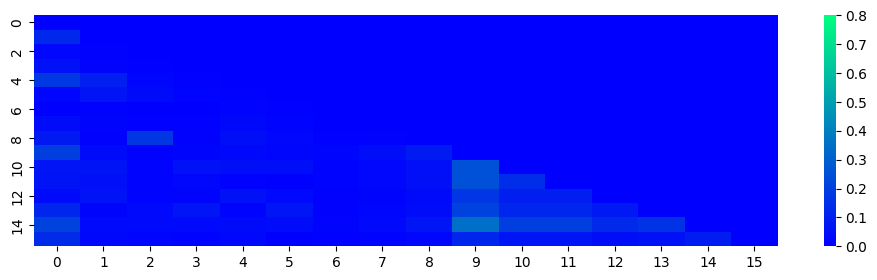

In [28]:
sns.heatmap(np.tril(ols_data.corr().abs(), k=-1), cmap='winter', vmin=0, vmax=.8);

In [31]:
ols_data['const'] = np.ones(len(ols_data))
ols = OLS(
    ols_data[dep_var], 
    ols_data.drop(dep_var, axis=1),
    hasconst=True,
).fit()

In [32]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:          pi_perc_error   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.300
Date:                Sat, 16 Mar 2024   Prob (F-statistic):              0.194
Time:                        12:45:16   Log-Likelihood:                -815.50
No. Observations:                1376   AIC:                             1663.
Df Residuals:                    1360   BIC:                             1747.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
hhinc_midpoint   1.398e-06   5.91e-06     

## VAR: Is the aggregated perception error systematic ?

In [19]:
sub = pd_join_freq(
    hhp.set_index('date_recorded')[['pi_perc_MY', 'delta_pe_MY']].drop_duplicates(), 
    pi[['pi_de_surprise_Y', 'pi_de_Y', 'pi_de_estimate_Y']],
    'M', keep_left_index=False).drop_duplicates()
sub['pi_perc_err'] = sub.pi_de_Y - sub.pi_perc_MY

<AxesSubplot: xlabel='M'>

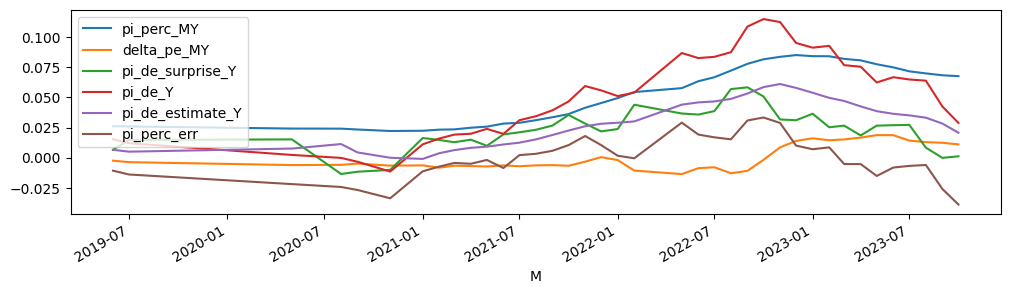

In [20]:
sub.dropna().plot()

Interestingly suprise inflation of lag1 drives expectation error most

In [21]:
cols_endog, cols_exog = ['pi_perc_err'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var = VAR(sub[cols_endog + cols_exog].diff().dropna()).fit(maxlags=2)
print(var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, Mar, 2024
Time:                     11:18:00
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -30.6819
Nobs:                     34.0000    HQIC:                  -31.3031
Log likelihood:           413.887    FPE:                1.87661e-14
AIC:                     -31.6246    Det(Omega_mle):     1.07018e-14
--------------------------------------------------------------------
Results for equation pi_perc_err
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.001250         0.001291           -0.968           0.333
L1.pi_perc_err             -0.102877         0.182464           -0.564           0.573
L1.pi_de_surprise_Y         0.

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
# A = np.asarray([[1, 0, 0],['E', 1, 0],['E', 'E', 1]])
# B = np.asarray([['E', 0, 0], [0, 'E', 0], [0, 0, 'E']])
# A_guess = np.asarray([0.5, 0.25, -0.38])
# B_guess = np.asarray([0.5, 0.1, 0.05])

# cols_endog, cols_exog = ['pi_perc_err'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
# svar = SVAR(sub[cols_endog + cols_exog].diff().dropna(), 'AB', A=A, B=B).fit(maxlags=2)
# svar.irf().plot()

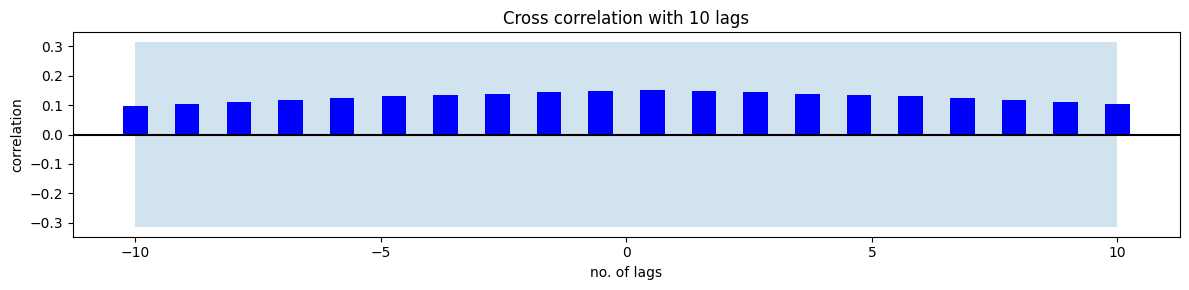

In [23]:
cross_corr(sub.pi_perc_MY, sub.pi_de_Y);

## Delta exp - perc: aggregate analysis

In [24]:
cols_endog, cols_exog = ['delta_pe_MY'], ['pi_de_surprise_Y', 'pi_de_estimate_Y']
var = VAR(sub[cols_endog + cols_exog].diff().dropna()).fit(maxlags=2)
print(var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 16, Mar, 2024
Time:                     11:18:06
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -32.3751
Nobs:                     36.0000    HQIC:                  -32.9764
Log likelihood:           467.134    FPE:                3.50779e-15
AIC:                     -33.2988    Det(Omega_mle):     2.05843e-15
--------------------------------------------------------------------
Results for equation delta_pe_MY
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.000230         0.000463            0.498           0.619
L1.delta_pe_MY              0.742947         0.179575            4.137           0.000
L1.pi_de_surprise_Y        -0.

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# News analysis

## overview on news and narratives

In [34]:
sub = topics.drop(['M_policy',], axis=1).drop_duplicates().copy() #.iloc[:300]

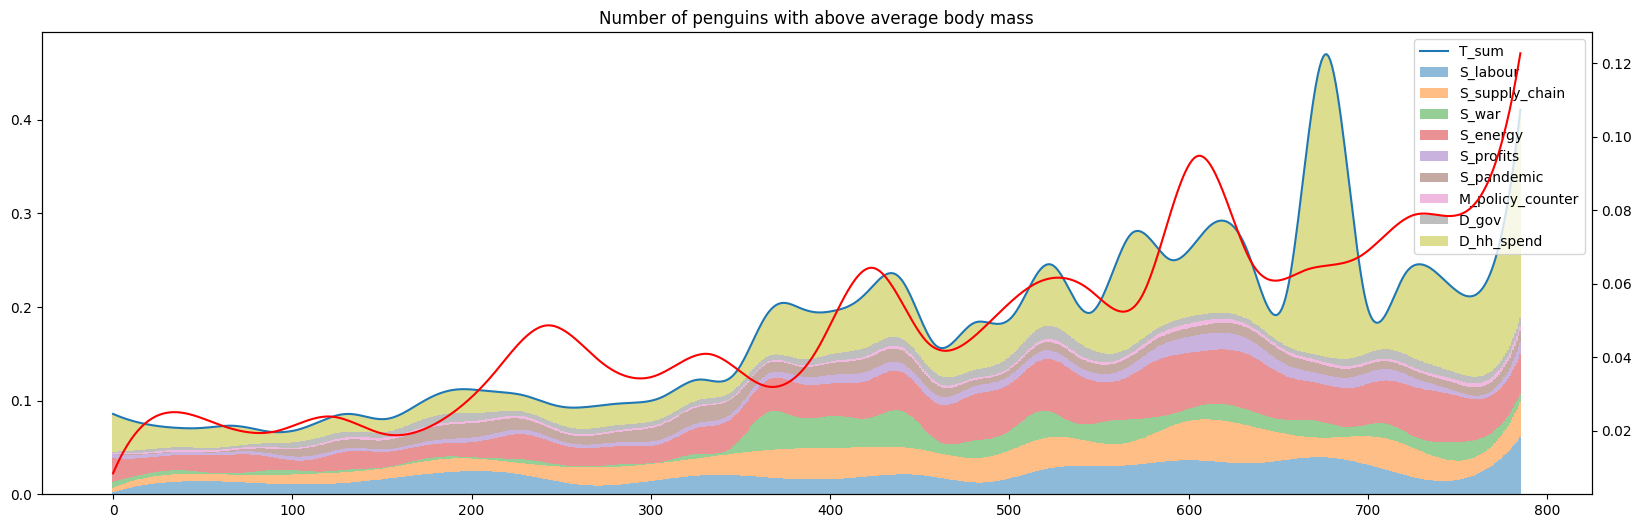

In [13]:
fig, ax = plt_stacked_bar(sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1))

ax.plot(sub.T_sum.values, label='T_sum')
ax.twinx().plot(sub.D_inflation.values, color='red', label='D_inflation')
ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right");

''

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


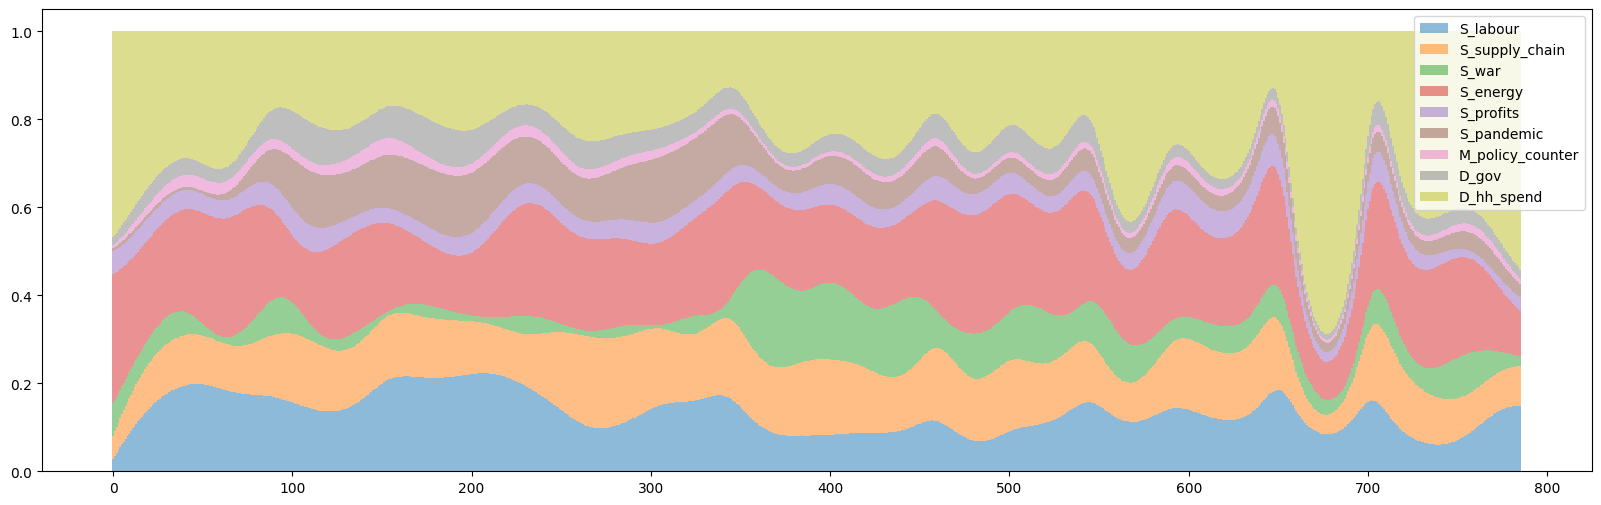

In [106]:
fig, ax = plt_stacked_bar(
    sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).apply(lambda x: x / x.sum(), axis=1)
)
ax.legend()
;

In [43]:
X = sub.drop(['D_inflation', 'T_sum', 'T_sum_diff_lag'], axis=1).diff().dropna()

In [65]:
scaler = StandardScaler().fit(X)
X_std = pd.DataFrame(scaler.transform(X), X.index, X.columns)
pca = PCA(n_components=5).fit(X_std)

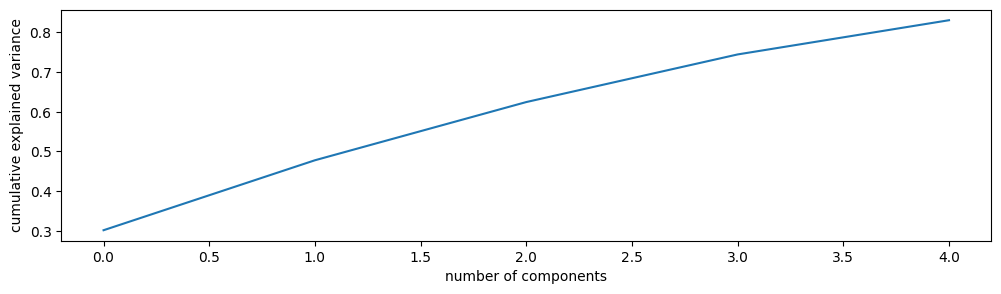

In [66]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

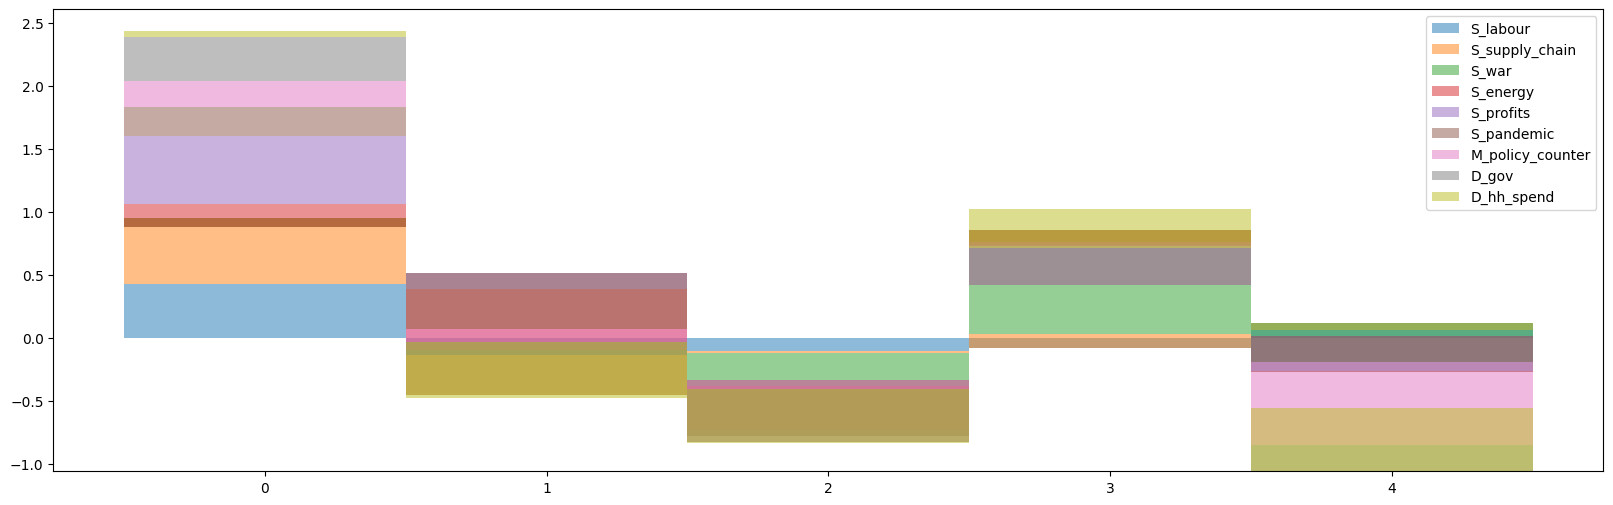

In [67]:
fig, ax = plt_stacked_bar(pd.DataFrame(pca.components_, columns = X.columns))
ax.legend(X.columns)

Text(0.5, 1.0, 'Components across time')

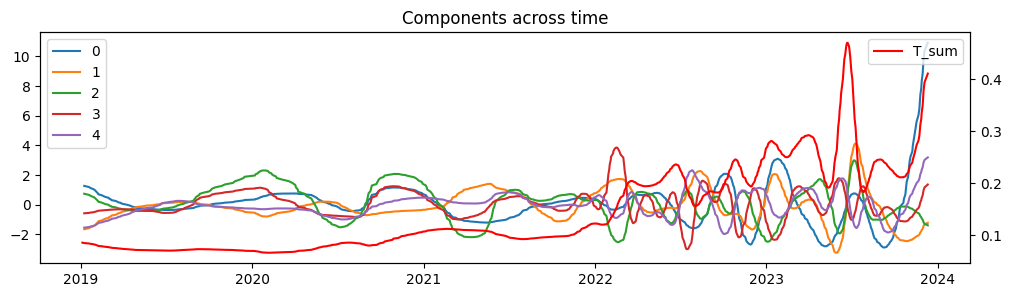

In [71]:
fig, ax = plt.subplots()

ax.plot(sub.index[1:], (pca.components_ @ X_std.T).T);
ax2 = ax.twinx()
ax2.plot(sub.T_sum, color='red')
ax.legend([*range(pca.n_components)] + ['T_sum'])
ax2.legend(['T_sum'])
plt.title('Components across time')

## war and inflation as given by hh concern

In [75]:
sub = df[['week_recorded', 'percprob_war', 'percprob_covid']].copy().dropna()
sub = sub.groupby('week_recorded').mean()
sub = pd_join_freq(sub, topics[['S_war', 'S_pandemic']].drop_duplicates() * 500, 'W', keep_left_index=False)
sub = sub.loc[~sub.index.duplicated()]

In [76]:
# for col in sub:
#     adf_test_summary(sub[col])

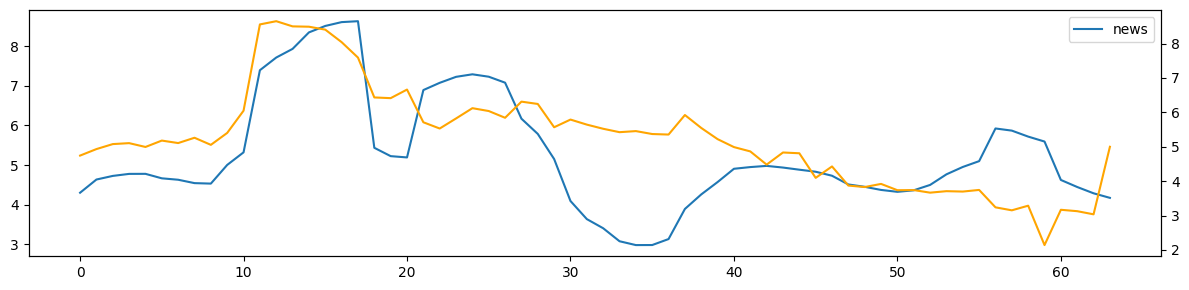

In [77]:
fig, ax = plt.subplots(1,1)
ax.plot(sub.S_pandemic.values, label='news')
ax.twinx().plot(sub.percprob_covid.values, color='orange')
ax.legend(['news', 'perceived'])
ax.legend()
plt.tight_layout()

In [84]:
select_coint_rank(sub[['S_pandemic', 'percprob_covid']].dropna(), 1, 10).summary()

r_0,r_1,test statistic,critical value
0,2,26.60,18.40
1,2,9.246,3.841


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


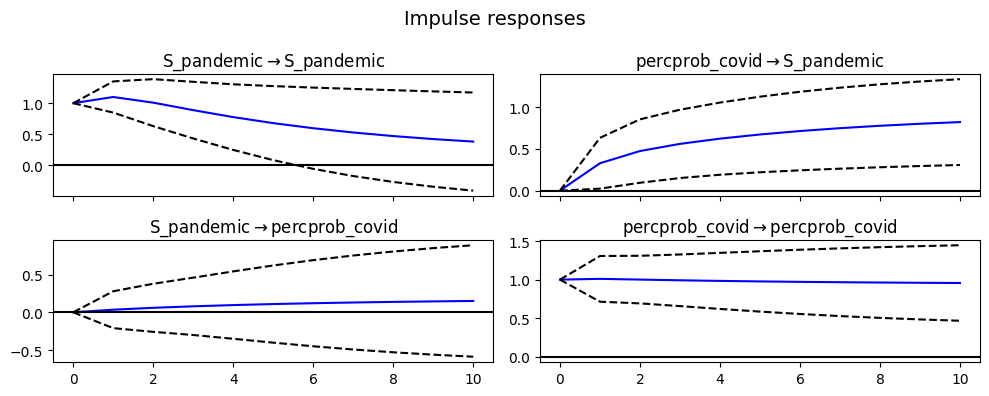

In [85]:
var = VECM(sub[['S_pandemic', 'percprob_covid']], coint_rank=1).fit()
var.irf().plot(figsize=(10,4))
plt.tight_layout(); 

# Macro analysis

## VECM: Does surprise inflation elicit higher news-paper reporting?

Following Dräger (2015) VECM to analyse:
$$ X_t = \Gamma X_{t-1} + u_t $$ 
where
$$X_t = (\pi_t, \pi^p_t, \pi^e_{t-12}, \Delta N_{t-1})$$

### with inflation monthly

<AxesSubplot: xlabel='M'>

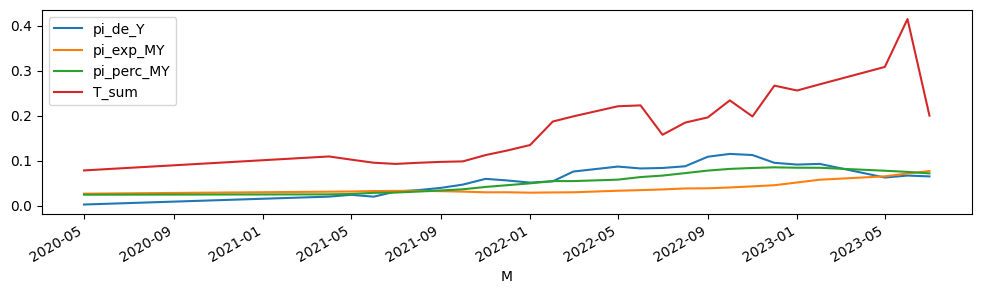

In [71]:
sub = pd_groupby(df.set_index('date_recorded'), ['pi_de_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
sub.plot()

In [72]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_order(sub, maxlags=3) # signif=0.05)
jtest.summary()

pi_de_Y ADF p-val: 0.22268558157000867
pi_exp_MY ADF p-val: 1.0
pi_perc_MY ADF p-val: 0.2176634363900108
T_sum ADF p-val: 0.9852450166676453


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

,AIC,BIC,FPE,HQIC
0,-41.05,-40.06,1.530e-18,-40.82
1,-41.32,-39.53,1.391e-18,-40.90
2,-41.31,-38.73,2.319e-18,-40.70
3,-45.00*,-41.63*,2.186e-19*,-44.21*


In [73]:
vecm = VECM(sub, coint_rank=jtest.aic).fit()
vecm.summary();

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


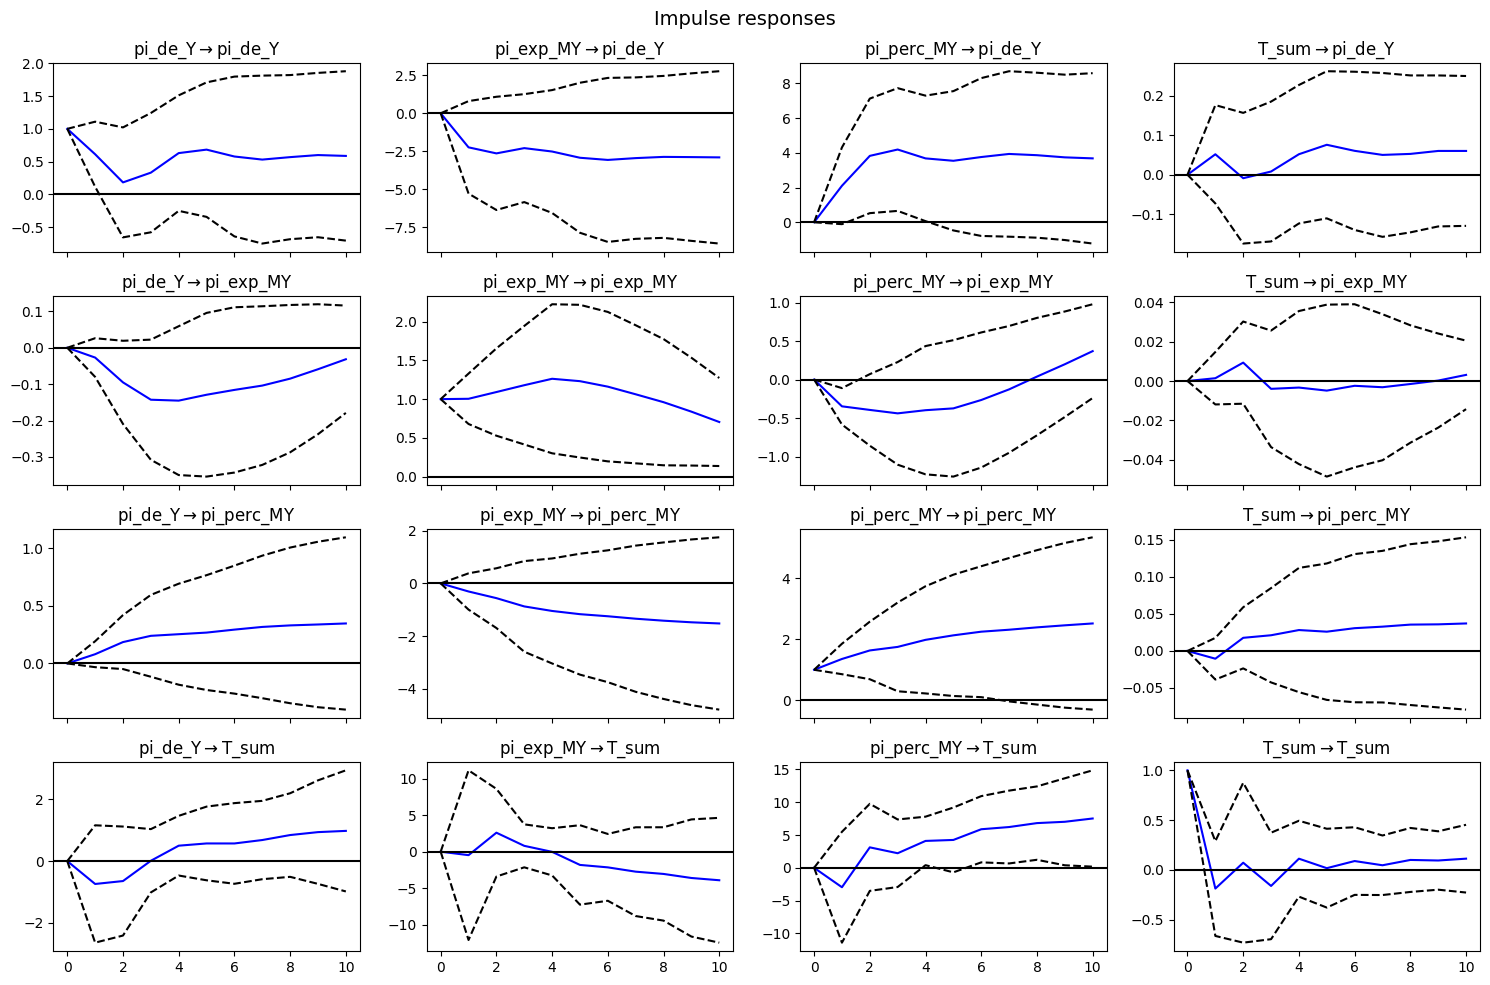

In [74]:
irf = vecm.irf()
irf.plot(figsize=(15,10))
plt.tight_layout()

### without inflation

In [75]:
sub = df.groupby('week_recorded')[['pi_exp_MY', 'pi_perc_MY', 'T_sum']].last().dropna()

In [76]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")
    
jtest = select_order(sub, maxlags=3) # signif=0.05)
jtest.summary()

pi_exp_MY ADF p-val: 1.0
pi_perc_MY ADF p-val: 0.22588785983187137
T_sum ADF p-val: 0.985109129831758


C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been pro

,AIC,BIC,FPE,HQIC
0,-31.50,-31.08,2.089e-14,-31.33
1,-32.13,-31.39,1.114e-14,-31.84
2,-32.68,-31.62*,6.474e-15,-32.27
3,-32.88*,-31.51,5.368e-15*,-32.34*


In [77]:
vecm = VECM(sub, coint_rank=jtest.aic).fit()
vecm.summary();

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


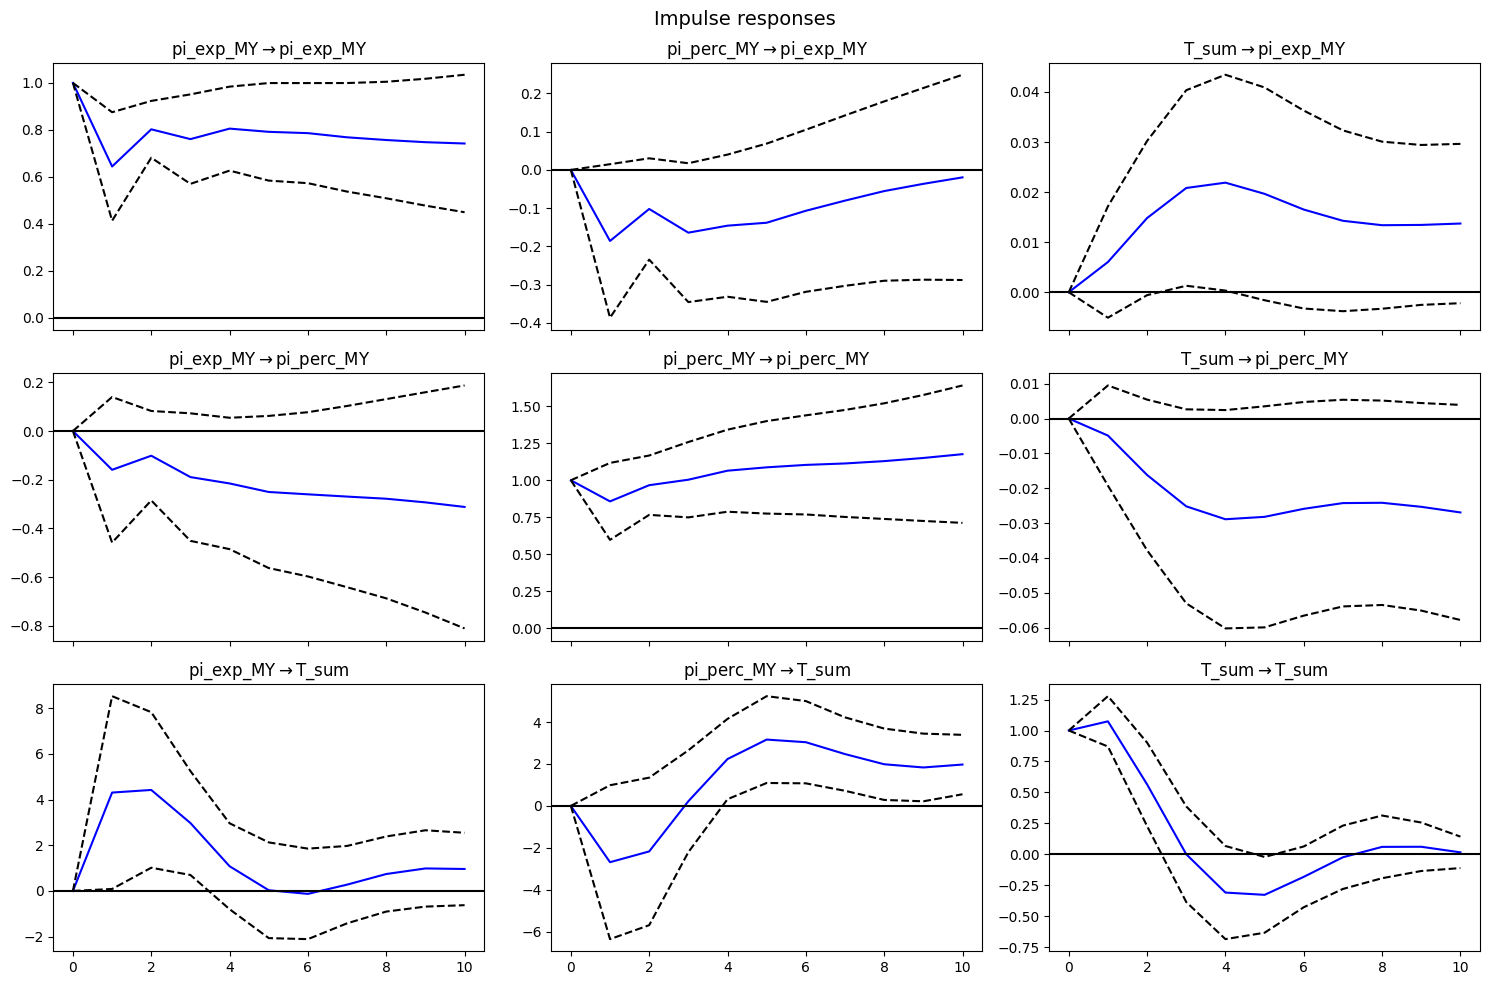

In [78]:
irf = vecm.irf()
irf.plot(figsize=(15,10))
plt.tight_layout()

## VAR: Does surprise inflation elicit higher news-paper reporting?

Same analysis as Dräger (2015) as VAR to analyse:
$$ \hat{X}_t = \Gamma \hat{X}_{t-1} + u_t $$ 
where
$$X_t = (\hat{\pi}_t, \hat{\pi}^p_t, \hat{\pi}^e_{t-12}, \hat{N}_t), \quad \mbox{where} \quad \hat{z}_t = z_t - z_{t-1} $$

In [81]:
sub = pd_groupby(df.set_index('date_recorded'), ['pi_de_Y', 'pi_exp_MY', 'pi_perc_MY', 'T_sum'], 'M', 'last').dropna()
sub_d = sub.diff().dropna().copy()

In [82]:
var = VAR(sub_d).fit()
# var.summary()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [85]:
# var.irf().plot()
# plt.tight_layout()

# Micro analysis

In [166]:
df_micro = pd_join_freq(
    hhp.set_index('date_recorded')[[
        'date_forecast', 'pi_perc', 'pi_perc_WY', 'id', 'hhinc_midpoint', 'debt', 'is_homeown', 'wealth_bank', 'is_unempl',
        'pinc_midpoint', 'eduwork', 'profession', 'delta_pe', 'pi_exp', 'hhinc',
    ]].copy(),
    pi[['pi_de_Y']],
    'M',
    keep_left_index=True).copy()
df_micro = pd_join_freq(df_micro, topics[['T_sum', 'T_sum_diff_lag']].drop_duplicates(), "D", keep_left_index=True, how='left').sort_index()
df_micro['week_recorded'] = df_micro.date_forecast.dt.to_period('W').dt.to_timestamp()

In [169]:
df_micro = pd_df_astype(df_micro, DICT_PARSE_COLS)

## panel structure sparsity and distance analysis

In [64]:
ind_cols = ['id', 'week_recorded']
sub = df[['pi_perc'] + ind_cols].copy().reset_index(drop=True).drop_duplicates()

filt = sub.groupby(ind_cols).pi_perc.last().unstack().count(axis=1) > 7
sub = sub.loc[sub.id.isin(list(filt[filt].index))].set_index(ind_cols).sort_index()
sub = sub.dropna()
filt.sum()

377

In [219]:
dist = df.groupby('id')[['hhinc_midpoint', 'pi_perc_error', 'debt', 'wealth_bank', 'eduschool', 'hhsize', 'ecbtrust']].last().astype(float)

dist = dist.loc[sub.index.get_level_values(0)]
dist = dist.loc[~dist.index.duplicated()]
# dist = scipy.spatial.distance.cdist(dist, dist.mean(axis=0).values[None])
dist = scipy.spatial.distance.cdist(dist, dist)

dist[np.isnan(dist)] = np.array(list([0] * np.isnan(dist).sum()))
dist = dist.mean(axis=0)

<AxesSubplot: xlabel='week_recorded', ylabel='id'>

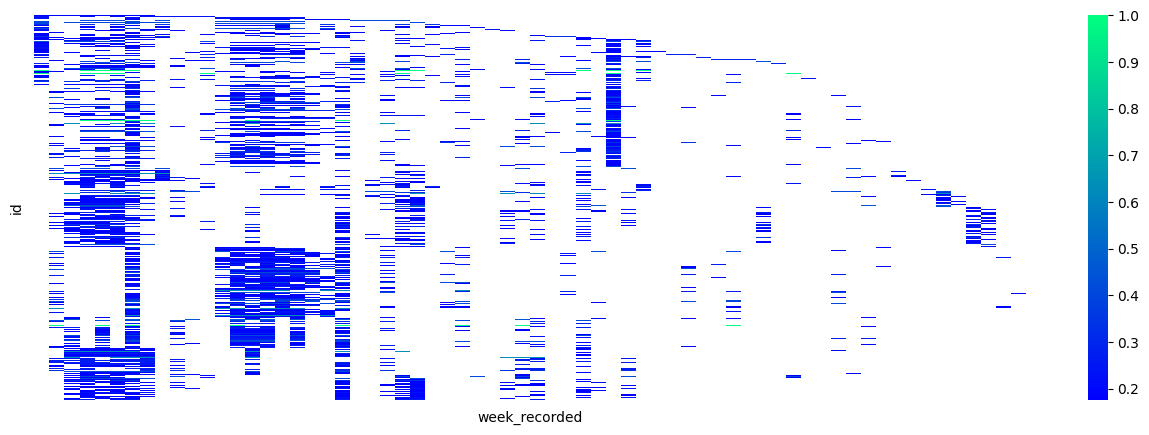

In [230]:
A = ~sub.unstack().isna()
A = (A * ((dist - dist.min()) / (dist.max() - dist.min()))[:, None]).replace({0: np.nan})
A.columns = A.columns.get_level_values(1)

fig = plt.figure(figsize=(16,5))
sns.heatmap(A, xticklabels=False, yticklabels=False, cmap='winter')

## POLS: How do news affect inflation perception on an individual level?

Investigate the effect of news $N_t$ on inflation perception $\pi^p_{i,t}$:
$$ \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [170]:
cols = ['T_sum_diff_lag', 'hhinc', 'pi_de_Y', 'is_unempl',] # 'wealth_bank',]  #'debt',]
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_perc']

In [171]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 4
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((8055, 5), 1492)

In [172]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                pi_perc   R-squared:                        0.2580
Estimator:                   PanelOLS   R-squared (Between):              0.8040
No. Observations:                8055   R-squared (Within):               0.2580
Date:                Sat, Mar 16 2024   R-squared (Overall):              0.7510
Time:                        12:13:34   Log-likelihood                 2.009e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      151.80
Entities:                        1492   P-value                           0.0000
Avg Obs:                       5.3988   Distribution:                 F(15,6548)
Min Obs:                       5.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             131.53
                            

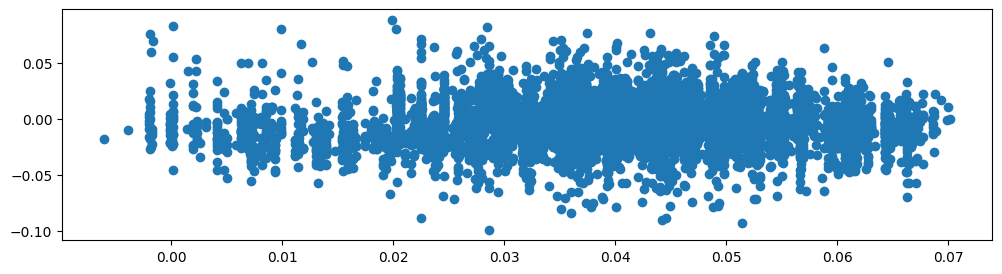

In [173]:
plt.scatter(m_fe.predict().values, m_fe.resids.values)

In [174]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 109.1957241778076, 'LM p-val': 1.080209178139093e-22, 'F-Stat': 27.656910147726904, 'F p-val': 7.689086948782225e-23}


In [175]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.0029516411291652


In [176]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 44.8670405830344
degrees of freedom: 15
p-Value: 8.036073195600013e-05


# Exp 2

Influence of news on future change in inflation $\pi^e_{i,t} - \pi^p_{i,t}$
$$ \pi^e_{i,t} - \pi^p_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [177]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y', 'debt', 'is_unempl', 'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['delta_pe']

In [180]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 3
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((2982, 7), 715)

In [181]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:               delta_pe   R-squared:                        0.0524
Estimator:                   PanelOLS   R-squared (Between):             -7.1849
No. Observations:                2982   R-squared (Within):               0.0524
Date:                Sat, Mar 16 2024   R-squared (Overall):             -1.2833
Time:                        12:14:03   Log-likelihood                    9175.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.6385
Entities:                         715   P-value                           0.0000
Avg Obs:                       4.1706   Distribution:                 F(22,2245)
Min Obs:                       4.0000                                           
Max Obs:                       6.0000   F-statistic (robust):             11.543
                            

In [182]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 510.9521106085795, 'LM p-val': 3.6747616918994694e-107, 'F-Stat': 102.52617493348107, 'F p-val': 1.2472171740277174e-117}


In [183]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

2.174481040553191


In [184]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 237.59000063710695
degrees of freedom: 22
p-Value: 4.305613879388328e-38


# Exp 3

Influence of news on expectation:
$$ \pi^e_{i,t} = \alpha_i + \beta N_t + \gamma X_{i,t} + \epsilon_{i,t} $$

In [199]:
cols = ['T_sum_diff_lag', 'hhinc_midpoint', 'pi_de_Y',]# 'debt',] # 'is_unempl', ] #'wealth_bank'] #, 'eduwork']
ind_cols = ['id', 'week_recorded']
dep_col = ['pi_exp']

In [200]:
sub = df_micro[ind_cols + cols + dep_col].copy().reset_index(drop=True)
filt = sub.groupby(ind_cols)[dep_col + cols].last()
filt = filt.dropna().reset_index().groupby('id').count().min(axis=1) > 5
sub = sub.loc[sub.id.isin(set(filt[filt].index))].set_index(ind_cols).sort_index().dropna()
sub.shape, filt.sum()

((29619, 4), 4300)

In [201]:
m_fe = PanelOLS(sub[dep_col], sub[cols], entity_effects=True).fit(cov_type='clustered', cluster_entity=True)
m_re = RandomEffects(sub[dep_col], sub[cols]).fit()
print(m_fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 pi_exp   R-squared:                        0.4398
Estimator:                   PanelOLS   R-squared (Between):              0.8507
No. Observations:               29619   R-squared (Within):               0.4398
Date:                Sat, Mar 16 2024   R-squared (Overall):              0.8014
Time:                        12:14:44   Log-likelihood                 7.752e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6624.9
Entities:                        4300   P-value                           0.0000
Avg Obs:                       6.8881   Distribution:                 F(3,25316)
Min Obs:                       6.0000                                           
Max Obs:                       12.000   F-statistic (robust):             3964.8
                            

In [202]:
# H0: Homoscedasticity is present
_ = sm.add_constant(pd.concat([m_fe.resids, sub[cols]], axis=1))
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, het_breuschpagan(_[['residual']], _.drop('residual', axis=1)))))

{'LM-Stat': 120.75848270962022, 'LM p-val': 5.297613746106355e-26, 'F-Stat': 40.412154323947405, 'F p-val': 4.720582243197312e-26}


In [203]:
durbin_watson_test_results = durbin_watson(m_fe.resids) 
print(durbin_watson_test_results)

1.9869566194668753


In [204]:
# H0: RE is to be preferred
hausman(m_fe, m_re)
hausman_results = hausman(m_fe, m_re)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 468.93478579004704
degrees of freedom: 3
p-Value: 2.5735022448161187e-101
